## DM-21329: Comparing DECam coadd templates of different resolutions

[DM-21230](https://jira.lsstcorp.org/browse/DM-21230) identified that our DECam HiTS templates were using the pipeline-default 0.33"/pixel, and that 0.2"/pixel provide a 2x decrease in the number of (false) DIASources. Subsequent Slack discussion suggested that the pixel scale should not matter so long as the PSF was Nyquist sampled and the correlated noise was handled correctly in the coaddition. The latter condition is not met, so while awaiting future algorithmic advances this ticket is to determine an empirical best choice for DECam.

This ticket is to produce HiTS templates for a small area for several pixel scales, ranging from (perhaps) 0.1"/pixel, including the instrumental pixel scale (0.26"/pixel), and up to and exceeding the Nyquist scale for the HiTS seeing distribution. The output is a plot of the number of detected DIASources as a function of the template pixel scale.

### Self-consistent configs are important when running `ap_pipe` with different template resolutions

I use a best seeing criterion and restrict the dataset to a handful of ccds in one field (Blind14A_04, which corresponds to Blind15A_26). This results in at least three coadd patches (or more, depending on the configured skymap resolution). Nearly all of the regions with data have 21 constituent visits. The processed images are on lsst-dev in `/project/mrawls/hits2014/rerun/2019_11` and the coadds are in reruns named `coadds1` through `coadds6`. The steps are:

* ingest the raw HiTS 2014 data and calibs and run `processCcd.py`
* `makeDiscreteSkyMap.py` with `--config skyMap.pixelScale` set to the present default (0.33), 0.2, 0.23, 0.26, 0.29, and 0.32
* `makeCoaddTempExp.py` with the `ap_pipe` `makeCoaddTempExp_goodSeeing` config as well as `--config select.nImagesMax=1000` and `select.maxPsfFwhm` set to 4.2, 6.93, 6.03, 5.33, 4.78, and 4.33, respectively (corresponding to the `pixelScale`s above)
* `assembleCoadd.py` with `--warpCompareCoadd` and `--id` manually set to include all patches which have a tempExp from the previous step (there are always at least 3 data-containing patches)
* `ap_pipe.py` using the HiTS 2015 dataset as science and the new coadds as templates

After this was complete, we decided to add a few more `pixelScale` resolutions: 0.13" (extremely high-res), 0.52" (extremely low-res), and 0.8" (ridiculously low-res). The `maxPsfFwhm` cut for the images that will make up the template was adjusted as before - `4.2 * 0.33 / pixelScale` - yielding 10.67, 2.67, and 1.73, respectively.

In [1]:
%matplotlib notebook

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import importlib

import lsst.daf.persistence as dafPersist

In [3]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
from diaObjectAnalysis import loadAllApdbObjects, loadAllApdbSources, plotDiaObjectsOnSky #, setObjectFilter
import plotLightcurve as plc  # in_ipynb, loadApdbObjects, loadApdbSources, patchFinder, plotLightcurve
from apdbPlots import makeSrcTableFlags

In [ ]:
# Only if you change anything in the code imported above
importlib.reload(plc)

### Load object and source tables from each rerun

In [4]:
def loadTables(repo, dbName='association.db'):
    butler = dafPersist.Butler(repo)
    dbPath = os.path.join(repo, dbName)
    objTable = loadAllApdbObjects(repo, dbName)
    srcTable = loadAllApdbSources(repo, dbName)
    flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTable, objTable)
    return objTable, srcTable, goodObj, goodSrc

In [5]:
objTable1, srcTable1, goodObj1, goodSrc1 = loadTables('/project/mrawls/hits2015/rerun/coaddtest1')
objTable2, srcTable2, goodObj2, goodSrc2 = loadTables('/project/mrawls/hits2015/rerun/coaddtest2')
objTable3, srcTable3, goodObj3, goodSrc3 = loadTables('/project/mrawls/hits2015/rerun/coaddtest3')
objTable4, srcTable4, goodObj4, goodSrc4 = loadTables('/project/mrawls/hits2015/rerun/coaddtest4')
objTable5, srcTable5, goodObj5, goodSrc5 = loadTables('/project/mrawls/hits2015/rerun/coaddtest5')
objTable6, srcTable6, goodObj6, goodSrc6 = loadTables('/project/mrawls/hits2015/rerun/coaddtest6')
objTable7, srcTable7, goodObj7, goodSrc7 = loadTables('/project/mrawls/hits2015/rerun/coaddtest7')
objTable8, srcTable8, goodObj8, goodSrc8 = loadTables('/project/mrawls/hits2015/rerun/coaddtest8')
objTable9, srcTable9, goodObj9, goodSrc9 = loadTables('/project/mrawls/hits2015/rerun/coaddtest9')

/opt/lsst/software/stack/stack/miniconda3-4.7.10-4d7b902/Linux64/ap_association/18.1.0-19-g0bedffc+2/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [6]:
goodObjList = [goodObj1, goodObj2, goodObj3, goodObj4, goodObj5, goodObj6, goodObj7, goodObj8, goodObj9]
goodSrcList = [goodSrc1, goodSrc2, goodSrc3, goodSrc4, goodSrc5, goodSrc6, goodSrc7, goodSrc8, goodSrc9]
allObjList = [objTable1, objTable2, objTable3, objTable4, objTable5, objTable6, objTable7, objTable8, objTable9]
allSrcList = [srcTable1, srcTable2, srcTable3, srcTable4, srcTable5, srcTable6, srcTable7, srcTable8, srcTable9]

### Print object and source counts
Apply an RA/Dec cut to ensure full spatial overlap between reruns

In [7]:
def applySpatialCut(df):
    spatialCut = (df.ra > 149.15) & (df.ra < 150) & (df.decl > 1.89) & (df.decl < 2.20)
    return df.loc[spatialCut]

In [8]:
pixelScales = [0.33, 0.2, 0.23, 0.26, 0.29, 0.32, 0.13, 0.52, 0.8]
goodObjLen = []
goodSrcLen = []
allObjLen = []
allSrcLen = []
for obj, src, allObj, allSrc in zip(goodObjList, goodSrcList, allObjList, allSrcList):
    goodObjLen.append(len(applySpatialCut(obj)))
    goodSrcLen.append(len(applySpatialCut(src)))
    allObjLen.append(len(applySpatialCut(allObj)))
    allSrcLen.append(len(applySpatialCut(allSrc)))

df = pd.DataFrame(list(zip(pixelScales, goodObjLen, goodSrcLen, allObjLen, allSrcLen)),
                  columns=['pixelScale', 'goodObjCount', 'goodSrcCount', 'allObjCount', 'allSrcCount'])

df.sort_values(by=['pixelScale'], inplace=True)

df

,pixelScale,goodObjCount,goodSrcCount,allObjCount,allSrcCount
6,0.13,1118,4804,2782,10847
1,0.20,1064,4551,2692,10418
2,0.23,1064,4689,2666,10618
3,0.26,1115,4565,2757,10528
4,0.29,1146,4609,2913,10784
5,0.32,1130,4482,2896,10555
0,0.33,1140,4468,2913,10535
7,0.52,1080,4616,2938,10906
8,0.80,1447,8140,4707,18221


### Plot the DIA Object and DIA Source count as a function of pixelScale

Note that "Flagged" Sources have one or more of the suspect, bad, or saturated center flags while "Good" Sources have none of these. Objects may be composed of a combination of Good and/or Flagged Sources.

<IPython.core.display.Javascript object>


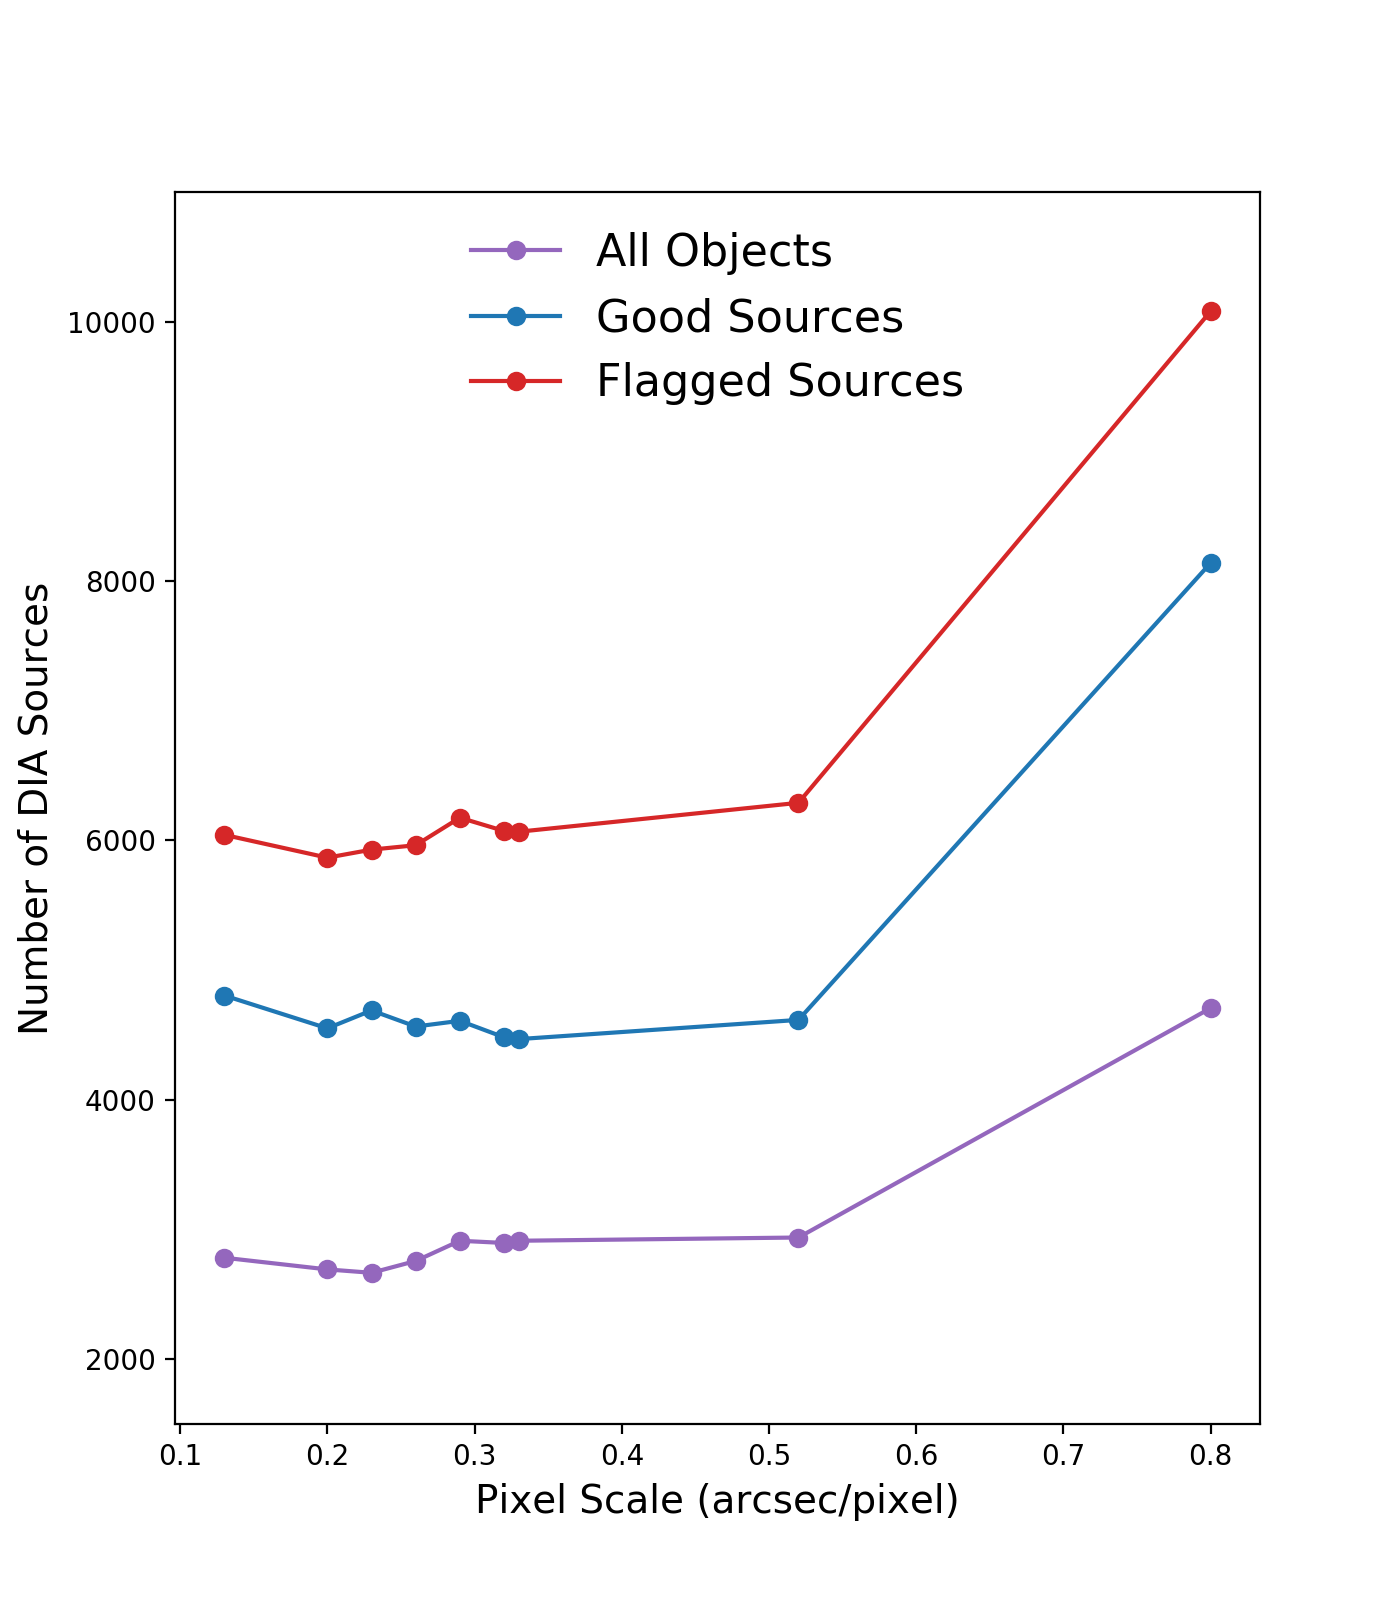

In [9]:
plt.figure(figsize=(7,8))

#plt.subplot(212)
plt.plot(df.pixelScale, df.allObjCount, marker='o', color='C4', label='All Objects')
plt.plot(df.pixelScale, df.goodSrcCount, marker='o', color='C0', label='Good Sources')
plt.plot(df.pixelScale, df.allSrcCount - df.goodSrcCount, marker='o', color='C3', label='Flagged Sources')
#plt.plot(df.pixelScale, df.allSrcCount, marker='o', color='C1', label='All Sources')
plt.xlabel('Pixel Scale (arcsec/pixel)', size=14)
plt.ylabel('Number of DIA Sources', size=14)
plt.gca().set_ylim([1500, 11000])
plt.legend(frameon=False, prop={'size': 16}, loc='upper center')

### Plot the DIA Objects on the sky for each rerun

In [10]:
def plotHitsOnSky(allList, goodList,
                  pixelScales=[0.33, 0.2, 0.23, 0.26, 0.29, 0.32, 0.13, 0.52, 0.8]):
    fig = plt.figure(figsize=(8, 10))

    for idx, (allThing, goodThing, pixelScale) in enumerate(zip(allList, goodList, pixelScales)):
        ax1 = fig.add_subplot(3, 3, idx+1)
        ax1.set_xlim([150, 149.15])
        ax1.set_ylim([1.89, 2.20])
        ax1.scatter(allThing['ra'], allThing['decl'], s=1, alpha=0.2, c='C3')  # all incl bad, red
        ax1.scatter(goodThing['ra'], goodThing['decl'], s=10, alpha=0.2, c='C0')  # good, blue
        plt.title(pixelScale)

        if idx == 3:
            ax1.set_ylabel('Dec (deg)')
        if idx == 7:
            ax1.set_xlabel('RA (deg)')

        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

<IPython.core.display.Javascript object>


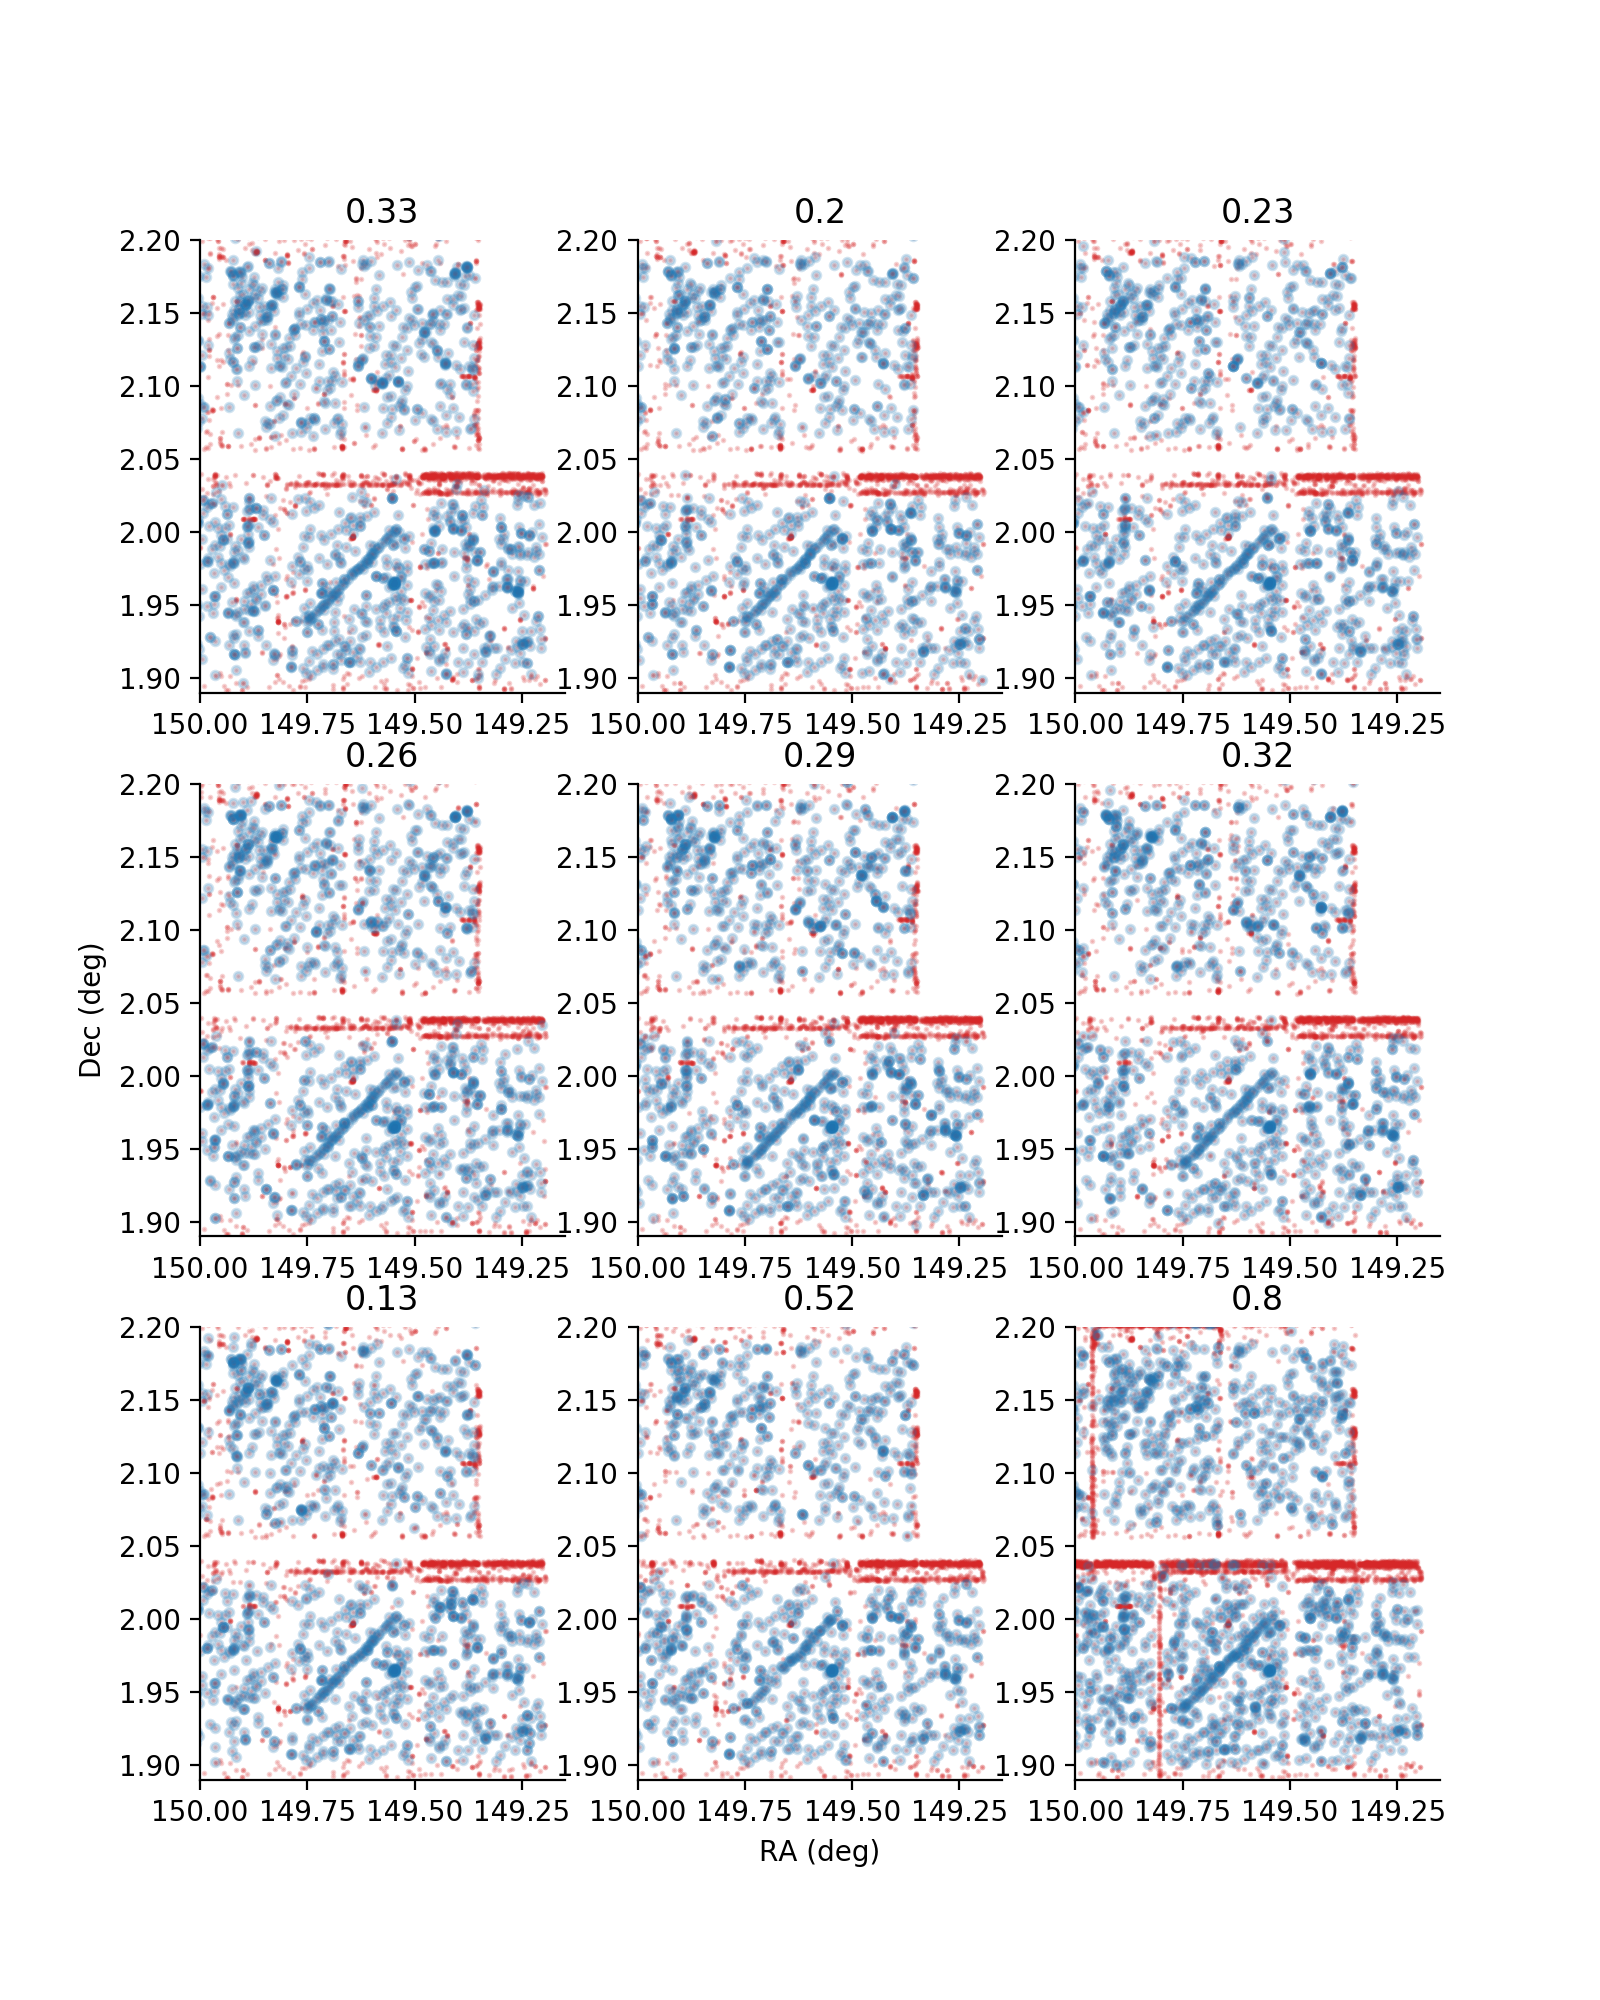

In [11]:
plotHitsOnSky(allObjList, goodObjList)

### The instrumental pixel scale for DECam (0.26"/pixel) is a good choice for template resolution

When this ticket was originally made, a larger difference was seen between ap_pipe runs on the HiTS dataset with lower- vs higher- resolution templates. Much of this difference was likely due to misconfiguration, and in particular the need to scale the allowed maxPsfFwhm for selecting constituent images for a template **along with** the desired template skymap pixel scale.

There is only a small difference in source (and object) counts between the old default, 0.33"/pixel, and the instrumental pixel scale for DECam, 0.26"/pixel. Nevertheless, the instrumental pixel scale is a sensible default, and there are about 5\% fewer DIA Objects than the 0.33"/pixel case.

Going down to an extremely high resolution template (small pixel scale ~ 1/2 the instrumental value) is computationally inefficient and does not improve the source or object counts. Going up to an extremely low resolution template (large pixel scale > 2x the instrumental value) does eventually produce a large quantity of spurious detections.

I therefore recommend adopting 0.26"/pixel as the new default for DECam.